## Pre-processing

In [1]:
import numpy as np
import pandas as pd

UG_courses = ["BOA","BOB","BOC","BOE","BSC"]
Df = pd.read_csv("synthetic_Data_truncated_normal_approach2.csv")
print("size of dataframe:",Df.shape)
Df["COURSE_CODE"] = Df["COURSE_CODE"].fillna('not_taking')
Df = Df[Df.columns].fillna('0')
Df.isnull().sum().sum()

Df = Df.loc[Df['COURSE_CODE'] != 'not_taking']
Df = Df.reset_index()
X = Df[Df.columns.difference(['CODE_DESCR_mast','COURSE_CODE'])]
y = Df[['CODE_DESCR_mast','COURSE_CODE']]
print("X has size:",X.shape, " and y has size:",y.shape)


size of dataframe: (24017, 108)
X has size: (5437, 107)  and y has size: (5437, 2)


In [2]:
## select column that needs to do binary encoding 
subject_course_list = []
for course in UG_courses:
    for i in range(0,16):
        subject_course_list += [course+'subject'+str(i+1)]
profile_title_list = X.columns.difference(subject_course_list)

useless_profile_title_list = ['STU_ID_PROXY','UG_course','CODE_DESCR_bach','FACULTY_CODE_mast','LANGUAGE_TEST_SCORE','LANGUAGE_TEST_TYPE']+['FACULTY_CODE_mast']
# data cleaning, to sparse, or useless
useful_profile_title_list= list(set(profile_title_list)-set(useless_profile_title_list))
column_title_need_onehotEncode = ['COURSE_CREDITS_REQ_bach','FACULTY_CODE_bach','LOCATION_CODE_bach','top5_bach_bach',
                                  'AGE_BAND','STATE','HOME_LANGUAGE','ATAR_BAND',
                                  'COURSE_CREDITS_REQ_mast','LOCATION_CODE_mast','STUDY_YEAR_mast','N_SUBJECTS_mast']
X.isnull().sum().sum()

print("X has size:",X.shape)


X has size: (5437, 107)


In [3]:

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

####binary encoder
encoder = LabelBinarizer()
# Y_values = encoder.fit_transform(y["COURSE_CODE"].values)
Y_values = y["COURSE_CODE"].values
X_part1 = pd.DataFrame({})
for column in column_title_need_onehotEncode:
    column_values=X[column_title_need_onehotEncode][column].astype(str)
    binarised_x = encoder.fit_transform(column_values.values)
    X_part1 = pd.concat([X_part1,pd.DataFrame(binarised_x)],axis=1)
X_part2 = X[list(set(useful_profile_title_list)-set(column_title_need_onehotEncode))]
X_part2 = X_part2.reset_index(drop=True)
X_values = pd.concat([pd.DataFrame(X_part1),X_part2], axis = 1)

print("X has size:",X_values.shape, " and y has size:",Y_values.shape)


X has size: (5437, 89)  and y has size: (5437,)


# modelling without Synthetic



In [4]:
def accuracy_at_n(n,recomm,Ytest,order = "1_to_n"):
    res = [0]*n
    total = len(Ytest)
    i =[0]*n
    j = list(range(n))[1:]+[n]
    if order == "n_to_1":
        i= list(range(n))
        i = list(map(lambda x: -1*x, i))[1:]+[0]
        j = [n]*n
    #Ytest = Ytest.reset_index(drop = True)
    for index, row in recomm.iterrows():
        for each in range(n):
            if Ytest[index] in row.values[i[each]:j[each]]:
                res[each] +=1   
    res = list(map(lambda x:round(x/total,3), res))
    return res,order


In [5]:
from sklearn import metrics

def add_res(n,res,model,method,SynData,X_train,X_test,Y_test):
    Y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test) 
    n=n
    best_n = np.argsort(-probs, axis=1)[:,:-n]
    #then find the associated SOC code for each prediction
    top_class = cls.classes_[best_n]
    #cast to a new dataframe
    top_class_df = pd.DataFrame(data=top_class)    
#     print(top_class_df[:5])
    acc,order = accuracy_at_n(n,top_class_df,Y_test)
    this_row = {"method":method,
            "with Synthetic Data":SynData,
            "Train set size":int(X_train.shape[0]),
            "Test set size":int(X_test.shape[0]),
             "f1_score_weighted":metrics.f1_score(Y_test, Y_pred, average="weighted"),
            "accuracy_score":metrics.accuracy_score(Y_test, Y_pred),}
    for i in range(n):
        this_row["accuracy at "+str(i+1)] = acc[i]
    res = res.append(this_row,ignore_index=True)
    return res



In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, Y_train, Y_test = train_test_split(X_values.values, Y_values, test_size=0.2, random_state=27)

res_dict = pd.DataFrame(data = {"method":[],
            "with Synthetic Data":[],
            "Train set size":[],
            "Test set size":[],
             "f1_score_weighted":[],
            "accuracy_score":[],
            })
n=10

In [7]:

import timeit

start = timeit.default_timer()
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

cls = DecisionTreeClassifier()
cls.fit(X_train, Y_train)

res_dict = add_res(n,res_dict,cls,"DecisionTreeClassifier",False,X_train,X_test,Y_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Time in seconds:  0.2812625000000004


In [8]:
res_dict

# print(top_class_df)


,method,with Synthetic Data,Train set size,Test set size,f1_score_weighted,accuracy_score,accuracy at 1,accuracy at 10,accuracy at 2,accuracy at 3,accuracy at 4,accuracy at 5,accuracy at 6,accuracy at 7,accuracy at 8,accuracy at 9
0,DecisionTreeClassifier,0.0,4349.0,1088.0,0.54715,0.545956,0.546,0.593,0.548,0.556,0.565,0.57,0.574,0.577,0.59,0.593


In [9]:
import timeit

start = timeit.default_timer()

from sklearn.naive_bayes import BernoulliNB
cls = BernoulliNB()
cls.fit(X_train, Y_train)
res_dict = add_res(10,res_dict,cls,"BernoulliNB",False,X_train,X_test,Y_test)
stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Time in seconds:  0.20700640000000092


In [10]:
import timeit

start = timeit.default_timer()

from sklearn.naive_bayes import GaussianNB
cls = GaussianNB()
cls.fit(X_train, Y_train)
res_dict = add_res(10,res_dict,cls,"GaussianNB",False,X_train,X_test,Y_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 


Time in seconds:  0.30020870000000244


In [11]:
import timeit
start = timeit.default_timer()

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

grid_params = {'n_neighbors':[40,50,55,60,65,70,75,80,85,90,100],
              'weights':['uniform',],
              'metric':['manhattan']}
grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
cls  = grid.fit(X_train, Y_train)
best_parameters = grid.best_params_
print("best parameters are:",best_parameters)
best_result = grid.best_score_
print("best result is :",best_result)

res_dict = add_res(10,res_dict,cls,"KNeighborsClassifier",False,X_train,X_test,Y_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Fitting 3 folds for each of 11 candidates, totalling 33 fits


F:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    1.6s finished


best parameters are: {'metric': 'manhattan', 'n_neighbors': 55, 'weights': 'uniform'}
best result is : 0.3384683848551915
Time in seconds:  2.0422365000000013


In [12]:
import timeit
start = timeit.default_timer()

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
grid_params = {'loss':['deviance', 'exponential'],
              'learning_rate':[0.01, 0.1, 1],
              'n_estimators':[10,40,80,100]}
gbc_grid = GridSearchCV(GradientBoostingClassifier(random_state=0),grid_params,verbose = 1,cv=3,n_jobs = 5)
cls  = gbc_grid.fit(X_train, Y_train)

best_parameters = gbc_grid.best_params_
print("best parameters are:",best_parameters)
best_result = gbc_grid.best_score_
print("best result is :",best_result)

res_dict = add_res(10,res_dict,cls,"GradientBoostingClassifier",False,X_train,X_test,Y_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


F:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done  72 out of  72 | elapsed: 18.5min finished


best parameters are: {'learning_rate': 0.01, 'loss': 'deviance', 'n_estimators': 100}
best result is : 0.5939282739582589
Time in seconds:  1342.6510624


In [13]:
res_dict

,method,with Synthetic Data,Train set size,Test set size,f1_score_weighted,accuracy_score,accuracy at 1,accuracy at 10,accuracy at 2,accuracy at 3,accuracy at 4,accuracy at 5,accuracy at 6,accuracy at 7,accuracy at 8,accuracy at 9
0,DecisionTreeClassifier,0.0,4349.0,1088.0,0.547150,0.545956,0.546,0.593,0.548,0.556,0.565,0.570,0.574,0.577,0.590,0.593
1,BernoulliNB,0.0,4349.0,1088.0,0.557519,0.590993,0.591,0.881,0.678,0.753,0.792,0.819,0.837,0.850,0.865,0.874
2,GaussianNB,0.0,4349.0,1088.0,0.508193,0.502757,0.503,0.847,0.626,0.684,0.721,0.767,0.787,0.803,0.814,0.829
3,KNeighborsClassifier,0.0,4349.0,1088.0,0.225735,0.335478,0.337,0.689,0.450,0.531,0.581,0.610,0.631,0.649,0.664,0.681
4,GradientBoostingClassifier,0.0,4349.0,1088.0,0.549937,0.599265,0.599,0.836,0.705,0.746,0.762,0.774,0.790,0.801,0.818,0.825


# Modelling With Synthetic

In [14]:

X_part2 = X_part2.reset_index(drop = True)
X_part1 = X_part1.reset_index(drop = True)
X_part3 = X[subject_course_list]
X_part3= X_part3.reset_index(drop = True)
X2_values = pd.concat([pd.DataFrame(X_part1),X_part2,X_part3],axis = 1)
print(X2_values.shape)
from sklearn.model_selection import train_test_split
import numpy as np
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2_values.values, Y_values, test_size=0.2, random_state=27)


(5437, 169)


### Decision Tree

In [15]:

import timeit

start = timeit.default_timer()
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

cls = DecisionTreeClassifier()
cls.fit(X2_train, Y2_train)
res_dict = add_res(10,res_dict,cls,"DecisionTreeClassifier",True,X2_train,X2_test,Y2_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Time in seconds:  0.5891808999999739


### Naive Bayes

In [16]:
import timeit

start = timeit.default_timer()

from sklearn.naive_bayes import BernoulliNB
cls = BernoulliNB()
cls.fit(X2_train, Y2_train)
res_dict = add_res(10,res_dict,cls,"BernoulliNB",True,X2_train,X2_test,Y2_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Time in seconds:  0.28479779999997845


In [17]:
import timeit

start = timeit.default_timer()

from sklearn.naive_bayes import GaussianNB
cls = GaussianNB()
cls.fit(X2_train, Y2_train)
res_dict = add_res(10,res_dict,cls,"GaussianNB",True,X2_train,X2_test,Y2_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 


Time in seconds:  0.7568638999998711


In [18]:
import timeit
start = timeit.default_timer()
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
grid_params = {'n_neighbors':[30,40,50,55,60,65,70,75,80,85,90,95,100],
              'weights':['uniform'],
              'metric':['manhattan']}
grid2 = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
cls  = grid2.fit(X2_train, Y2_train)

best_parameters = grid2.best_params_
print("best parameters are:",best_parameters)
best_result = grid2.best_score_
print("best result is :",best_result)
res_dict = add_res(10,res_dict,cls,"KNeighborsClassifier",True,X2_train,X2_test,Y2_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Fitting 3 folds for each of 13 candidates, totalling 39 fits


F:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    3.1s finished


best parameters are: {'metric': 'manhattan', 'n_neighbors': 65, 'weights': 'uniform'}
best result is : 0.342837470153812
Time in seconds:  3.75848649999989


In [22]:
import timeit
start = timeit.default_timer()

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
grid_params = {'loss':['deviance', 'exponential'],
              'learning_rate':[0.01, 0.1, 1],
              'n_estimators':[10,40,80,100]}
gbc_grid = GridSearchCV(GradientBoostingClassifier(random_state=0),grid_params,verbose = 1,cv=3,n_jobs = 5)
cls  = gbc_grid.fit(X2_train, Y2_train)

best_parameters = gbc_grid.best_params_
print("best parameters are:",best_parameters)
best_result = gbc_grid.best_score_
print("best result is :",best_result)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


F:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done  72 out of  72 | elapsed: 28.4min finished


best parameters are: {'learning_rate': 0.01, 'loss': 'deviance', 'n_estimators': 100}
best result is : 0.5720855445293226


In [23]:
res_dict = add_res(10,res_dict,cls,"GradientBoostingClassifier",True,X2_train,X2_test,Y2_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start)

Time in seconds:  3138.0343378


In [24]:
res_dict

,method,with Synthetic Data,Train set size,Test set size,f1_score_weighted,accuracy_score,accuracy at 1,accuracy at 10,accuracy at 2,accuracy at 3,accuracy at 4,accuracy at 5,accuracy at 6,accuracy at 7,accuracy at 8,accuracy at 9
0,DecisionTreeClassifier,0.0,4349.0,1088.0,0.547150,0.545956,0.546,0.593,0.548,0.556,0.565,0.570,0.574,0.577,0.590,0.593
1,BernoulliNB,0.0,4349.0,1088.0,0.557519,0.590993,0.591,0.881,0.678,0.753,0.792,0.819,0.837,0.850,0.865,0.874
2,GaussianNB,0.0,4349.0,1088.0,0.508193,0.502757,0.503,0.847,0.626,0.684,0.721,0.767,0.787,0.803,0.814,0.829
3,KNeighborsClassifier,0.0,4349.0,1088.0,0.225735,0.335478,0.337,0.689,0.450,0.531,0.581,0.610,0.631,0.649,0.664,0.681
4,GradientBoostingClassifier,0.0,4349.0,1088.0,0.549937,0.599265,0.599,0.836,0.705,0.746,0.762,0.774,0.790,0.801,0.818,0.825
5,DecisionTreeClassifier,1.0,4349.0,1088.0,0.538227,0.534926,0.535,0.583,0.537,0.544,0.555,0.561,0.563,0.565,0.579,0.582
6,BernoulliNB,1.0,4349.0,1088.0,0.373419,0.399816,0.400,0.628,0.472,0.514,0.543,0.562,0.585,0.597,0.611,0.618
7,GaussianNB,1.0,4349.0,1088.0,0.125119,0.145221,0.145,0.316,0.179,0.201,0.221,0.242,0.255,0.267,0.275,0.296
8,KNeighborsClassifier,1.0,4349.0,1088.0,0.227900,0.336397,0.337,0.707,0.466,0.526,0.578,0.617,0.640,0.664,0.677,0.693
9,GradientBoostingClassifier,1.0,4349.0,1088.0,0.532676,0.585478,0.585,0.819,0.689,0.715,0.744,0.761,0.777,0.788,0.799,0.808


F:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


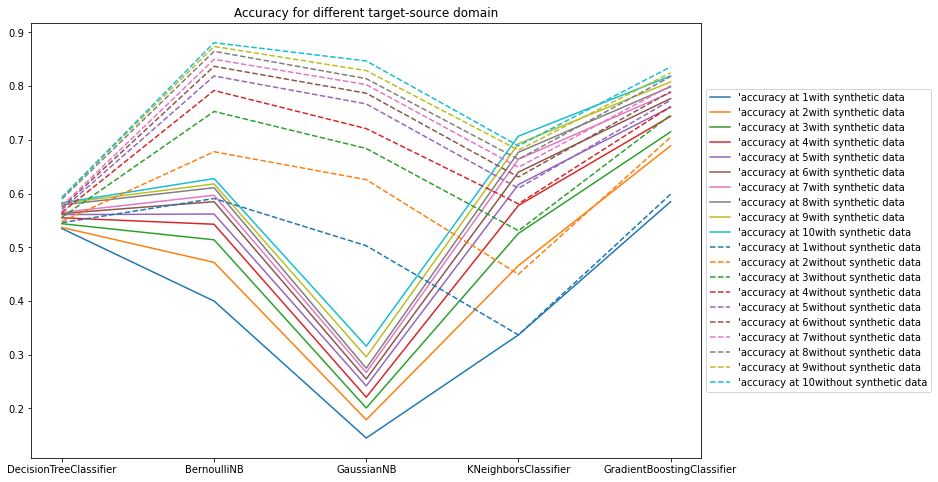

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

x = res_dict.loc[res_dict['with Synthetic Data'] == True]["method"]
for i in range(n):
    plt.plot(x,  res_dict.loc[res_dict['with Synthetic Data'] == True]['accuracy at '+str(i+1)],
             label =  "'accuracy at "+str(i+1)+"with synthetic data")
x2 = res_dict.loc[res_dict['with Synthetic Data'] == False]["method"]
for i in range(n):
    plt.plot(x2,  res_dict.loc[res_dict['with Synthetic Data'] == False]['accuracy at '+str(i+1)],
             label =  "'accuracy at "+str(i+1)+"without synthetic data", linestyle='dashed',)

    
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Accuracy for different target-source domain')
#plt.legend(loc = 'lower right', ncol=2,)
# Display a figure.
plt.show()

In [26]:
res_dict.to_csv('classification result.csv', mode='a', )
